# Машинное обучение, ВМК МГУ

## Практическое задание 3

#### Оценка: 11 баллов

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes, make_classification
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import math
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import OneHotEncoder

## Часть 1. Линейная регрессия

In [4]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

In [5]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [6]:
np.isnan(data.data).any()

False

### Задание 1. Обучение линейной регрессии.

In [34]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

Lasso()

In [33]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

In [43]:
print(lasso.coef_)

[  0.           0.         274.32681397  48.58596734   0.
   0.          -0.           0.         424.11801795   0.        ]


In [44]:
print(ridge.coef_)

[  20.86524598  -58.00074047  231.26919104  186.6748608    33.3106947
   -2.16998131 -150.95053633  141.35047981  250.75403183  123.1796716 ]


У Lasso регрессии 7 из 10 коэффициентов вектора весов равны 0.

У Ridge регрессии нет нулевых коэффициентов, и только один из них близок к 0, относительно всех остальных.

In [74]:
x = np.geomspace(0.001, 1000.0, 10)
not_null_coef_lasso = []
not_null_coef_ridge = []
for alpha in x:
    lasso = Lasso(alpha=alpha)
    ridge = Ridge(alpha=alpha)
    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    not_null_coef_lasso.append((lasso.coef_ != 0).sum())
    not_null_coef_ridge.append((ridge.coef_ != 0).sum())

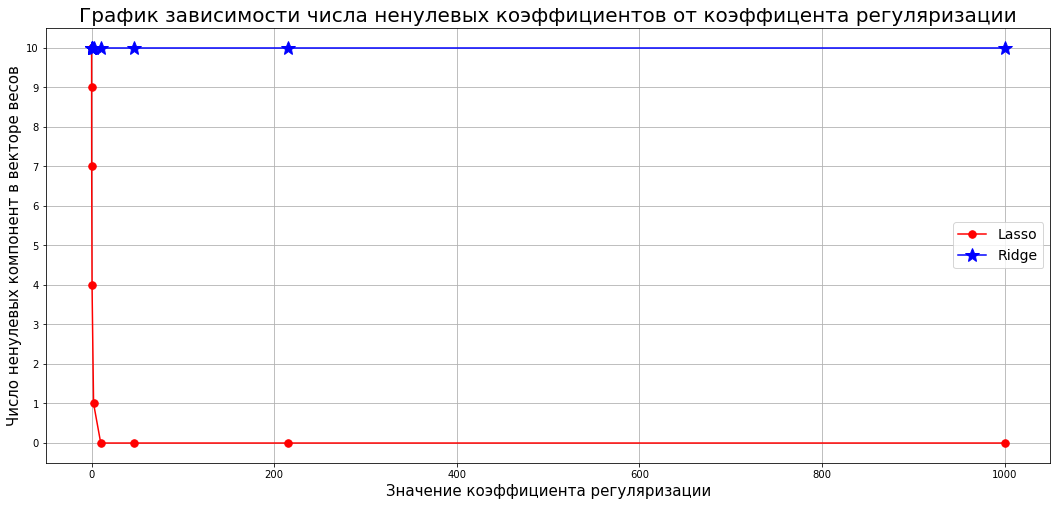

In [75]:
fig = plt.figure(figsize=(18, 8))
plt.plot(x, not_null_coef_lasso, color='red', marker='.', ms=15, label='Lasso')
plt.plot(x, not_null_coef_ridge, color='blue', marker='*', ms=15, label='Ridge')
plt.title('График зависимости числа ненулевых коэффициентов от коэффицента регуляризации', fontsize=20)
plt.xlabel('Значение коэффициента регуляризации', fontsize=15)
plt.ylabel('Число ненулевых компонент в векторе весов', fontsize=15)
plt.yticks(np.arange(0, 11))
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

График строился без учета bias в векторе весов, потому что он отвечает за центрированность данных.

Из графика видно, что Ridge регуляризация вообще не зануляет коэффициенты, а Lasso регуляризация зануляет, причем очень быстро. 
При коэффициенте регуляризации равным 10, Lasso уже зануляет все признаки.

In [82]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

In [87]:
res = ridge.predict(X_test)

In [89]:
print(math.sqrt(mean_squared_error(y_test, res)), mean_absolute_error(y_test, res), r2_score(y_test, res))

58.304415127748044 49.602846072752996 0.3598993868368464


In [102]:
reg_coef = np.geomspace(0.001, 1000.0, 30)
cv = GridSearchCV(Ridge(), {'alpha': reg_coef}, scoring='neg_root_mean_squared_error', refit=False, cv=KFold(n_splits=3).split(X_train))
cv.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000028AE78CFEB0>,
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
             refit=False, scoring='neg_root_mean_squared_error')

In [103]:
cv.cv_results_['mean_test_score']

array([-55.32569536, -55.29825129, -55.26904908, -55.23938568,
       -55.20731079, -55.16825629, -55.11984446, -55.06843402,
       -55.0353249 , -55.06401904, -55.23008529, -55.64756233,
       -56.45705018, -57.78822337, -59.71323345, -62.20834412,
       -65.11886031, -68.15444035, -70.97476333, -73.32808651,
       -75.12408303, -76.40512208, -77.27610342, -77.84939435,
       -78.21880057, -78.45359848, -78.60154832, -78.69426576,
       -78.75217155, -78.78825885])

In [106]:
cv.best_params_, cv.best_score_

({'alpha': 0.04520353656360243}, -55.035324902156994)

In [107]:
cv = GridSearchCV(Ridge(), {'alpha': reg_coef}, scoring='neg_mean_absolute_error', refit=False, cv=KFold(n_splits=3).split(X_train))
cv.fit(X_train, y_train)
cv.best_params_, cv.best_score_

({'alpha': 0.04520353656360243}, -44.04281145632435)

In [108]:
cv = GridSearchCV(Ridge(), {'alpha': reg_coef}, scoring='r2', refit=False, cv=KFold(n_splits=3).split(X_train))
cv.fit(X_train, y_train)
cv.best_params_, cv.best_score_

({'alpha': 0.04520353656360243}, 0.5066223239521289)

In [110]:
reg_coef = np.geomspace(0.001, 1000.0, 30)
loss_func = []
for rc in reg_coef:
    ridge = Ridge(alpha=rc)
    ridge.fit(X_train, y_train)
    w = np.append(ridge.intercept_, ridge.coef_)
    X = np.hstack((np.ones(X_train.shape[0])[:, np.newaxis], X_train))
    lf = np.sum((np.matmul(X, w[:, np.newaxis]).ravel() - y_train) ** 2) + rc * np.sum(w ** 2)
    loss_func.append(lf)

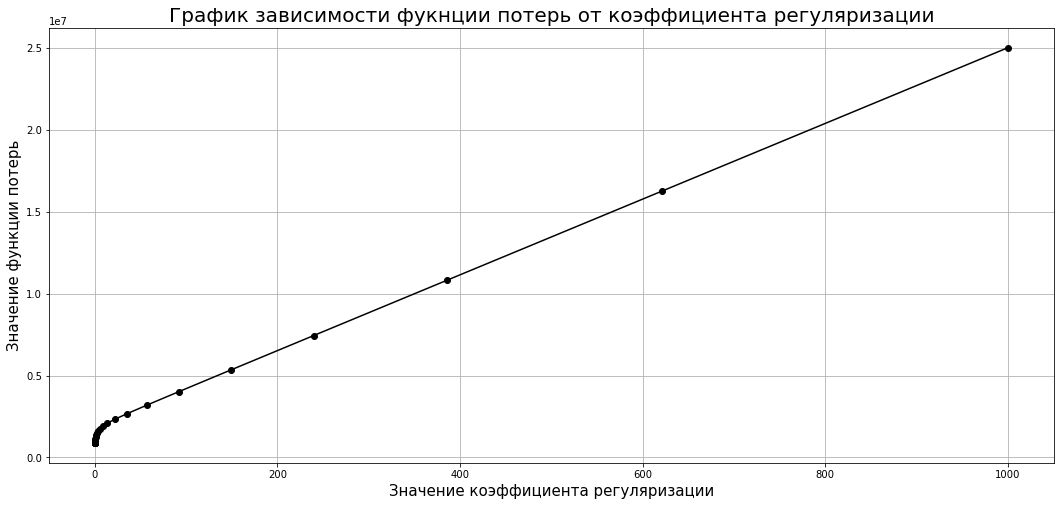

In [113]:
fig = plt.figure(figsize=(18, 8))
plt.plot(reg_coef, loss_func, color='black', marker='.', ms=12)
plt.title('График зависимости фукнции потерь от коэффициента регуляризации', fontsize=20)
plt.xlabel('Значение коэффициента регуляризации', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.show()

In [114]:
ridge = Ridge(alpha=0.04520353656360243)
ridge.fit(X_train, y_train)
res = ridge.predict(X_test)

In [115]:
print(math.sqrt(mean_squared_error(y_test, res)), mean_absolute_error(y_test, res), r2_score(y_test, res))

55.66861563676592 47.10820107701615 0.41646595402733555


После подбора коэффициента регуляризации на обучающей выборке по кросс-валидации для Ridge регрессии, качество на тестовой выборке улучшилось.

### Задание 2. Поиск объектов-выбросов.

In [10]:
y_train_pred = cross_val_predict(Ridge(alpha=0.04520353656360243), X_train, y_train, cv=5)

In [14]:
y_train_err = np.abs(y_train - y_train_pred)

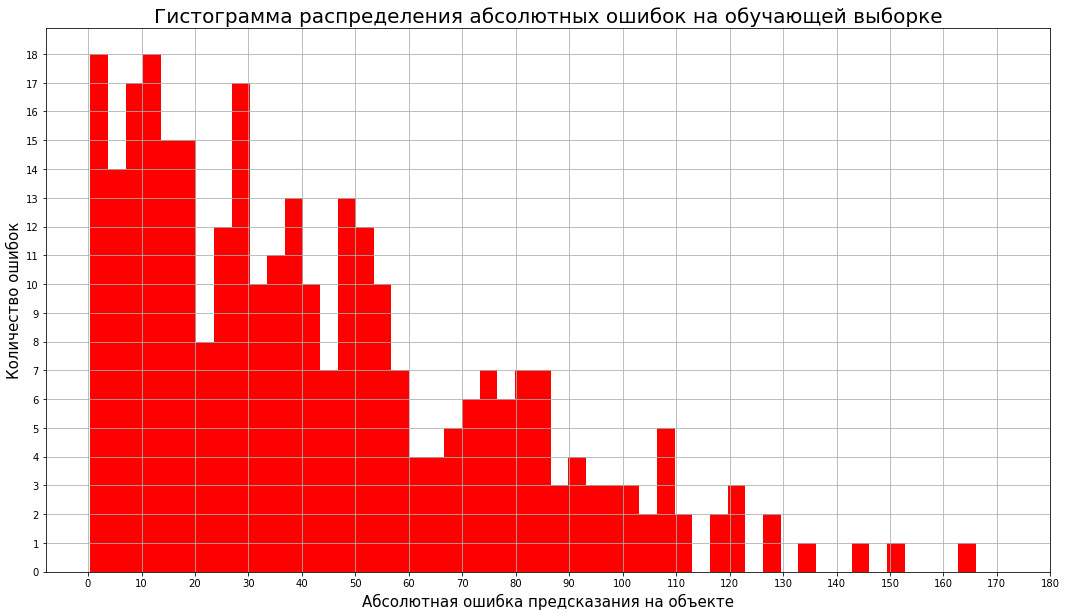

In [21]:
fig = plt.figure(figsize=(18, 10))
plt.hist(y_train_err, bins=50, color='red')
plt.title('Гистограмма распределения абсолютных ошибок на обучающей выборке', fontsize=20)
plt.xlabel('Абсолютная ошибка предсказания на объекте', fontsize=15)
plt.ylabel('Количество ошибок', fontsize=15)
plt.yticks(np.arange(0, 19))
plt.xticks(np.arange(0, 190, 10))
plt.grid()
plt.show()

Из гистограммы видно, что в данных есть выбросы, на которых переобучается модель.

Удалим их из обучающей выборки.

In [22]:
X_train_clean = X_train[y_train_err <= 130]
y_train_clean = y_train[y_train_err <= 130]

In [28]:
reg_coef = np.geomspace(0.001, 1000.0, 30)
cv = GridSearchCV(Ridge(), {'alpha': reg_coef}, scoring='neg_root_mean_squared_error', refit=False, cv=3)
cv.fit(X_train_clean, y_train_clean)
cv.best_params_, cv.best_score_

({'alpha': 0.04520353656360243}, -53.0019496495386)

In [23]:
ridge = Ridge(alpha=0.04520353656360243)
ridge.fit(X_train_clean, y_train_clean)
res = ridge.predict(X_test)

In [24]:
print(math.sqrt(mean_squared_error(y_test, res)), mean_absolute_error(y_test, res), r2_score(y_test, res))

55.83837395351979 47.11989106231309 0.4129016190834417


Качество почти не изменилось, но в отложенной выборке тоже есть выбросы, на которых наша модель штрафуется еще сильнее из-за
смещения. Значит на не выбросах модель работает лучше.

## Часть 2. Метод опорных векторов и калибровка вероятностней

In [75]:
X, y = make_classification(n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Задание 1. Обучение и применение метода опорных векторов.

In [76]:
linear_svc = LinearSVC(loss='squared_hinge', dual=True, C=1.0, max_iter=100000)
linear_svc.fit(X_train, y_train)
res = linear_svc.predict(X_test)

In [77]:
roc_auc_score(y_test, res)
#ROC-AUC

0.8490275510923723

In [78]:
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall[::-1], precision[::-1])
#PR-AUC

0.8865808239967357

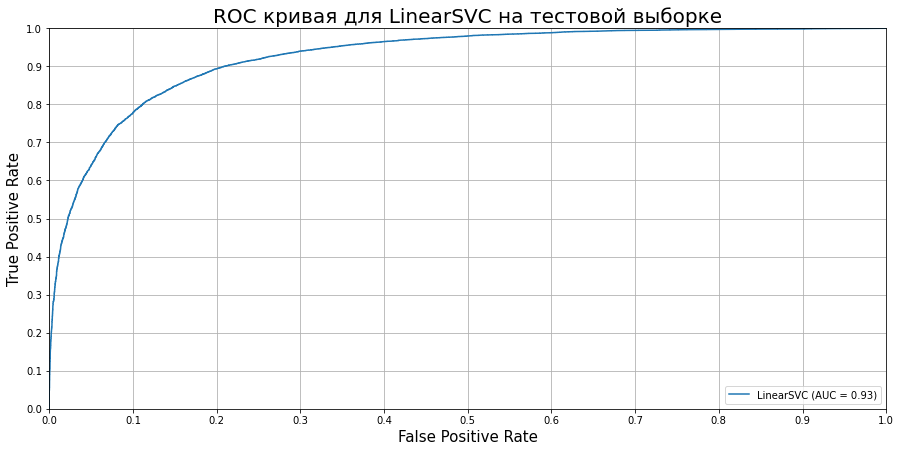

In [79]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('ROC кривая для LinearSVC на тестовой выборке', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_roc_curve(linear_svc, X_test, y_test, ax=ax)
plt.show()

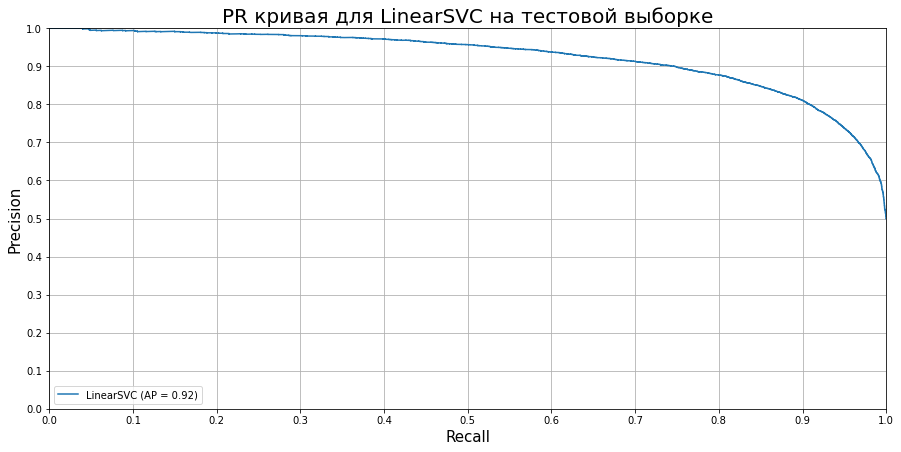

In [80]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('PR кривая для LinearSVC на тестовой выборке', fontsize=20)
ax.set_xlabel('Recall', fontsize=15)
ax.set_ylabel('Precision', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_precision_recall_curve(linear_svc, X_test, y_test, ax=ax)
plt.show()

In [64]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, class_sep=1.0)

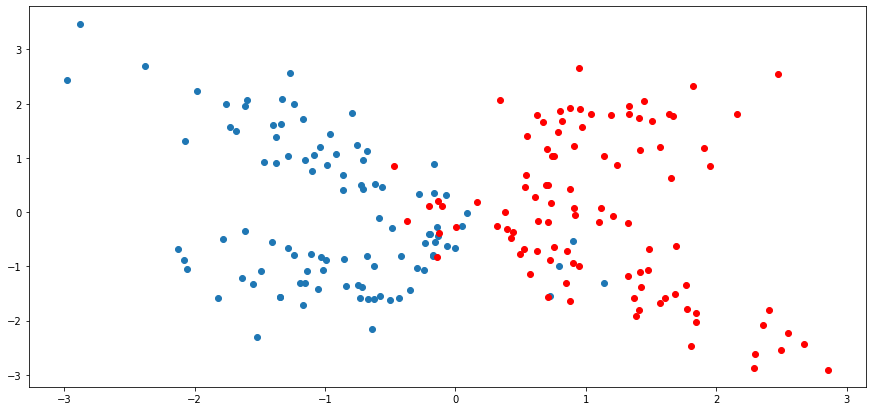

In [65]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(X[y == 0, 0].ravel(), X[y == 0, 1].ravel())
plt.scatter(X[y == 1, 0].ravel(), X[y == 1, 1].ravel(), color='red')
plt.show()

In [67]:
svc = SVC(C=1.0, kernel='linear')
svc.fit(X, y)

SVC(kernel='linear')

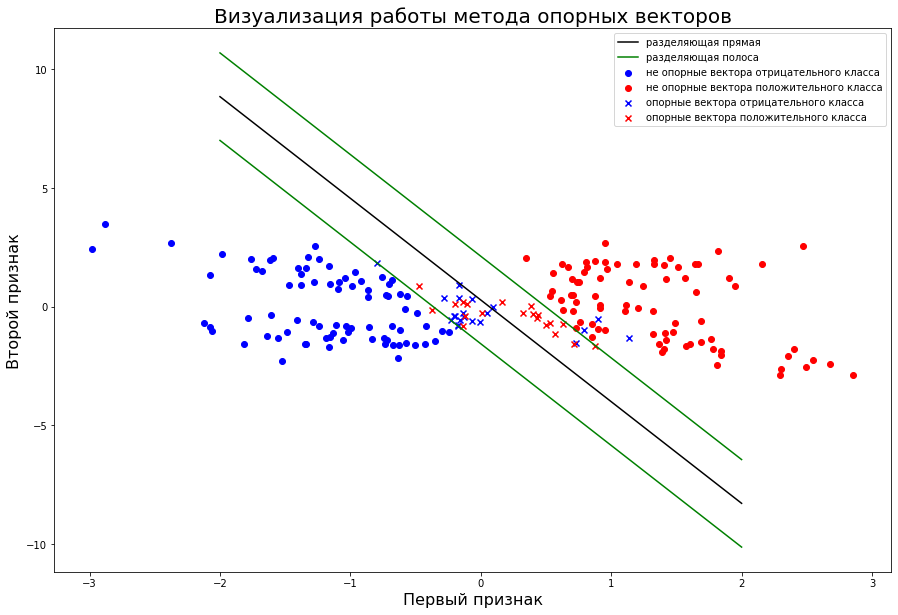

In [87]:
X_not_sup = X[np.delete(np.arange(X.shape[0]), svc.support_)]
y_not_sup = y[np.delete(np.arange(y.shape[0]), svc.support_)]
fig = plt.figure(figsize=(15, 10))
plt.title('Визуализация работы метода опорных векторов', fontsize=20)
plt.xlabel('Первый признак', fontsize=16)
plt.ylabel('Второй признак', fontsize=16)
plt.scatter(X_not_sup[y_not_sup == 0, 0].ravel(), X_not_sup[y_not_sup == 0, 1].ravel(), color='blue', label='не опорные вектора отрицательного класса')
plt.scatter(X_not_sup[y_not_sup == 1, 0].ravel(), X_not_sup[y_not_sup == 1, 1].ravel(), color='red', label='не опорные вектора положительного класса')
plt.scatter(X[svc.support_][y[svc.support_] == 0, 0].ravel(), X[svc.support_][y[svc.support_] == 0, 1].ravel(), color='blue', marker='x', label='опорные вектора отрицательного класса')
plt.scatter(X[svc.support_][y[svc.support_] == 1, 0].ravel(), X[svc.support_][y[svc.support_] == 1, 1].ravel(), color='red', marker='x', label='опорные вектора положительного класса')
plt.plot([-2, 2], [(2 * svc.coef_[0, 0] - svc.intercept_) / svc.coef_[0, 1], -(2 * svc.coef_[0, 0] + svc.intercept_) / svc.coef_[0, 1]], color='black', label='разделяющая прямая')
plt.plot([-2, 2], [(2 * svc.coef_[0, 0] - svc.intercept_) / svc.coef_[0, 1] - 1 / math.fabs(svc.coef_[0, 1]), -(2 * svc.coef_[0, 0] + svc.intercept_) / svc.coef_[0, 1] - 1 / math.fabs(svc.coef_[0, 1])], color='green', label='разделяющая полоса')
plt.plot([-2, 2], [(2 * svc.coef_[0, 0] - svc.intercept_) / svc.coef_[0, 1] + 1 / math.fabs(svc.coef_[0, 1]), -(2 * svc.coef_[0, 0] + svc.intercept_) / svc.coef_[0, 1] + 1 / math.fabs(svc.coef_[0, 1])], color='green')
plt.legend()
plt.show()

### Задание 2. Калибровка вероятностей.

In [18]:
def plot_calibration_curve(y_test, preds, ax):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / np.sum((preds >= l) & (preds < r)))
    ax.plot(bin_middle_points, bin_real_ratios)
    plt.show()

In [3]:
X, y = make_classification(n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
linear_svc = LinearSVC(loss='squared_hinge', dual=True, C=1.0, max_iter=100000)
linear_svc.fit(X_train, y_train)

LinearSVC(max_iter=100000)

In [6]:
log_reg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)
log_reg.fit(X_train, y_train)

LogisticRegression()

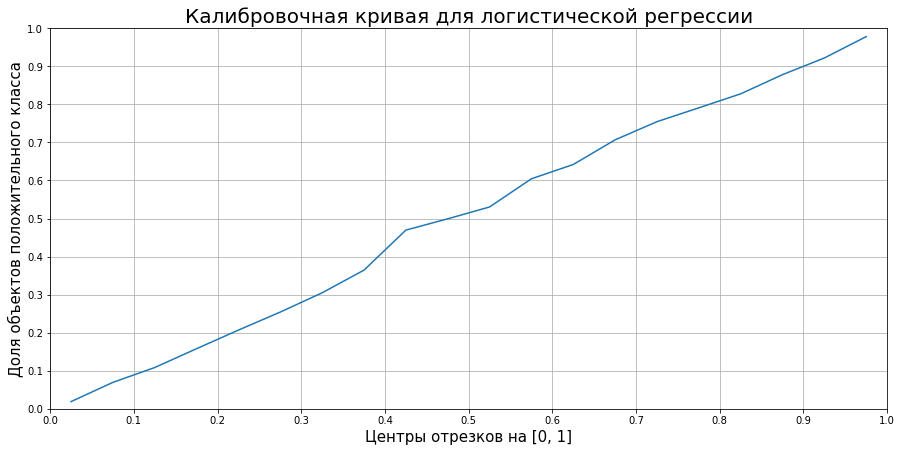

In [22]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('Калибровочная кривая для логистической регрессии', fontsize=20)
ax.set_xlabel('Центры отрезков на [0, 1]', fontsize=15)
ax.set_ylabel('Доля объектов положительного класса', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_calibration_curve(y_test, log_reg.predict_proba(X_test)[:, 1], ax)

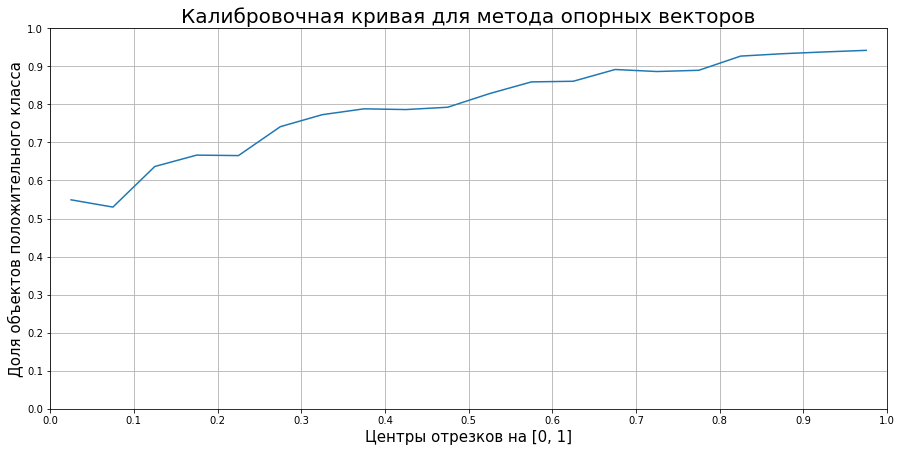

In [23]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('Калибровочная кривая для метода опорных векторов', fontsize=20)
ax.set_xlabel('Центры отрезков на [0, 1]', fontsize=15)
ax.set_ylabel('Доля объектов положительного класса', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_calibration_curve(y_test, linear_svc.decision_function(X_test), ax)

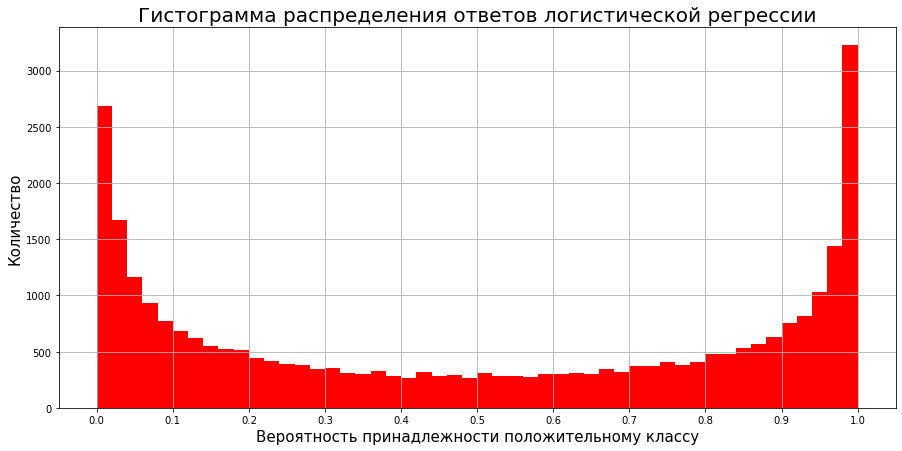

In [28]:
fig = plt.figure(figsize=(15, 7))
plt.hist(log_reg.predict_proba(X_test)[:, 1], bins=50, color='red')
plt.title('Гистограмма распределения ответов логистической регрессии', fontsize=20)
plt.xlabel('Вероятность принадлежности положительному классу', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.show()

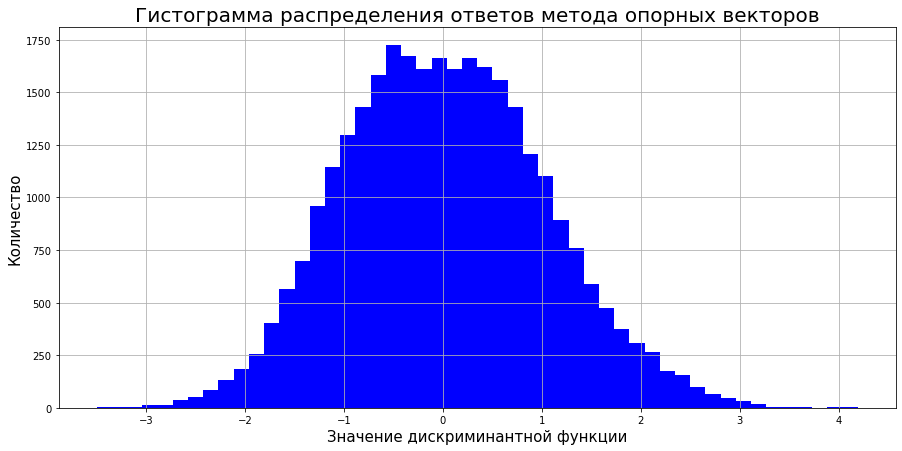

In [30]:
fig = plt.figure(figsize=(15, 7))
plt.hist(linear_svc.decision_function(X_test), bins=50, color='blue')
plt.title('Гистограмма распределения ответов метода опорных векторов', fontsize=20)
plt.xlabel('Значение дискриминантной функции', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.grid()
plt.show()

Калибровочная кривая логистической регрессии показывает высокое качество предсказания вероятностей.
Калибровочная кривая метода опорных векторов показывает очень плохое качество, потому что дискриминантная функция метода опорных векторов выдает не вероятности принадлежности к положительному классу.

Распределение ответов классификаторов различается тем, что у метода опорных векторов есть отрицательные значения. В методе опорных векторов чем больше по модулю значение дискриминантной функции, тем алгоритм более уверен в принадлежности объекта соответствующему классу. По распределению ответов SVC видно, что классы слабо разделимы, почти все значения дискриминантной функции содержатся на отрезке от -2 до 2.

У логистической регрессии распределение ответов тем лучше, чем оно больше по краям. Потому что в таком случае алгоритм с большей уверенностью относит объекты к классам. В нашем распределении наблюдается именно такая ситуация.

In [34]:
linear_svc_calib = CalibratedClassifierCV(linear_svc, method='sigmoid', cv='prefit')
linear_svc_calib.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(max_iter=100000), cv='prefit')

In [37]:
linear_svc_calib.predict_proba(X_test)

array([[0.43205998, 0.56794002],
       [0.1273892 , 0.8726108 ],
       [0.02683631, 0.97316369],
       ...,
       [0.47266848, 0.52733152],
       [0.34593095, 0.65406905],
       [0.23494781, 0.76505219]])

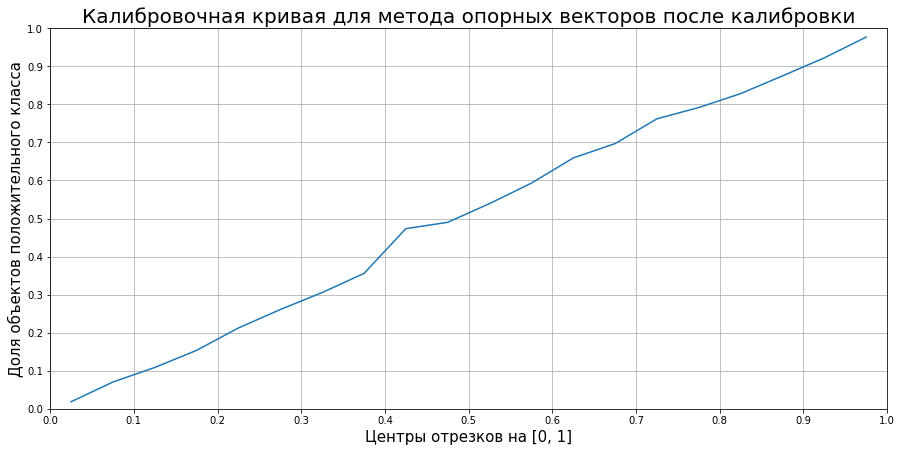

In [39]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('Калибровочная кривая для метода опорных векторов после калибровки', fontsize=20)
ax.set_xlabel('Центры отрезков на [0, 1]', fontsize=15)
ax.set_ylabel('Доля объектов положительного класса', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_calibration_curve(y_test, linear_svc_calib.predict_proba(X_test)[:, 1], ax)

После калибровки вероятностей метода опорных векторов калибровочная кривая сильно улучшилась.

Теперь откалиброванный метод опорных векторов можно использовать для оценки вероятностей принадлежности к классам.

## Часть 3. Логистическая регрессия

### Задание 3. Обучение логистической регрессии на реальных данных и оценка качества классификации.

In [61]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [62]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [39]:
log_reg = LogisticRegression(penalty='l2', C=0.7, solver='lbfgs', max_iter=10000, l1_ratio=None)
log_reg.fit(X_train.to_numpy(), y_train)

LogisticRegression(C=0.7, max_iter=10000)

In [45]:
res = log_reg.predict_proba(X_test.to_numpy())
res

array([[0.49009558, 0.50990442],
       [0.30813956, 0.69186044],
       [0.51525377, 0.48474623],
       ...,
       [0.4831496 , 0.5168504 ],
       [0.37766462, 0.62233538],
       [0.59952982, 0.40047018]])

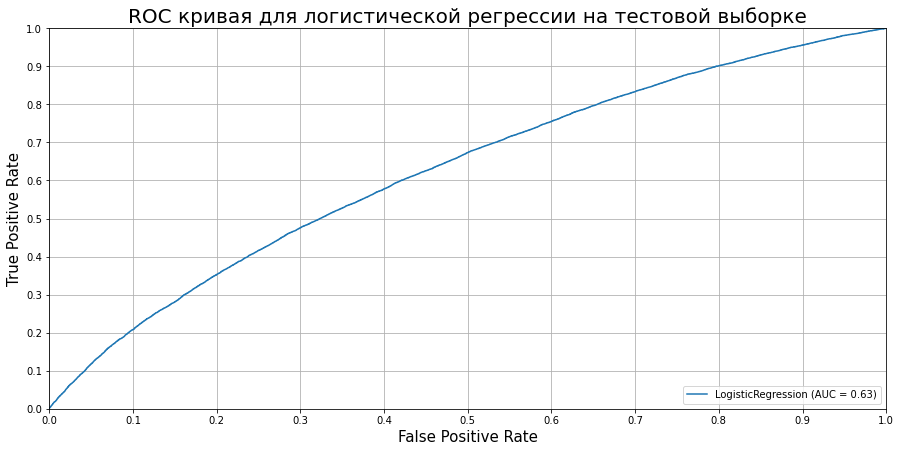

In [46]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('ROC кривая для логистической регрессии на тестовой выборке', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_roc_curve(log_reg, X_test, y_test, ax=ax)
plt.show()

In [47]:
roc_auc_score(y_test, res[:, 1])
#ROC-AUC

0.6251333662019205

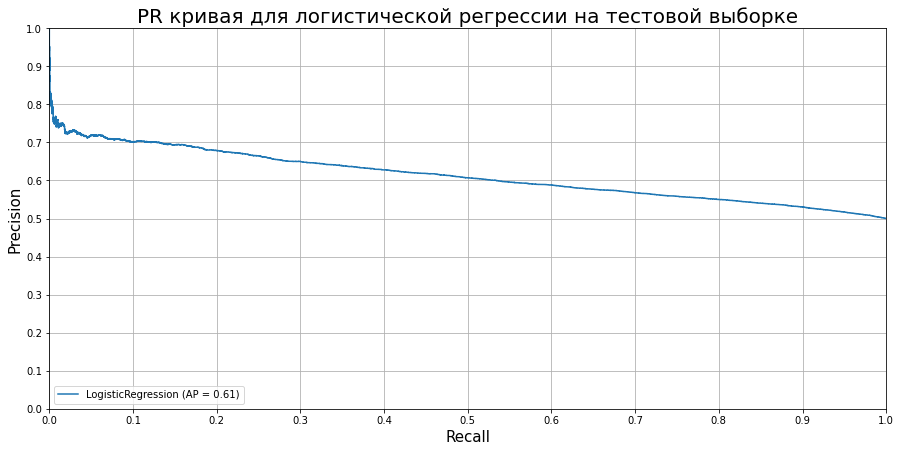

In [48]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('PR кривая для логистической регрессии на тестовой выборке', fontsize=20)
ax.set_xlabel('Recall', fontsize=15)
ax.set_ylabel('Precision', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_precision_recall_curve(log_reg, X_test, y_test, ax=ax)
plt.show()

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, res[:, 1])
auc(recall[::-1], precision[::-1])
#PR-AUC

0.6128320363412734

Рассмотрим PR кривую.
Из PR кривой видно, что среди объектов, которым алгоритм выдал самые большие вероятности принадлежности к положительному классу, очень много объектов отрицательного класса, поэтому PR кривая так резко падает в самом начале. Отсортировав предсказания в порядке убывания вероятностей положительного класса, на момент, когда мы возьмем последнюю метку "1", precision составляет примерно 0.5, то есть в той части выборки было поровну объектов положительного и отрицательного классов. Это не очень хорошо, так как мы бы хотели пронаблюдать приемущественно объекты положительного класса.

Рассмотрим ROC кривую.
Так же отсортировав мысленно объекты в порядке убывания вероятностей положительного класса, которые предсказала модель, видно, что правильные метки классов идут вперемешку. Хотелось бы видеть сначала приемущественно объекты положительного класса, а потом отрицательного класса, то есть более выпуклую ROC кривую.

В целом, классификация не очень хорошая, так как площади под кривыми небольшие.

### Задание 4. Изучение влияния регуляризатора на процесс обучения.

In [58]:
y_train_inverse = (y_train == 1) * -1 + (y_train == 0) * 1
y_test_inverse = (y_test == 1) * -1 + (y_test == 0) * 1

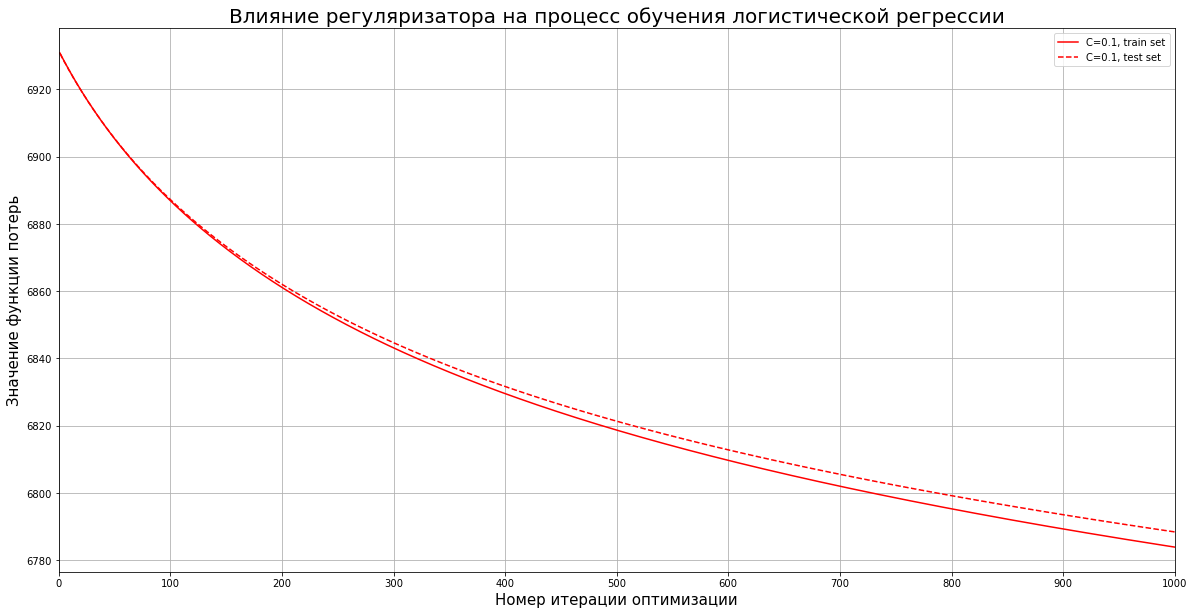

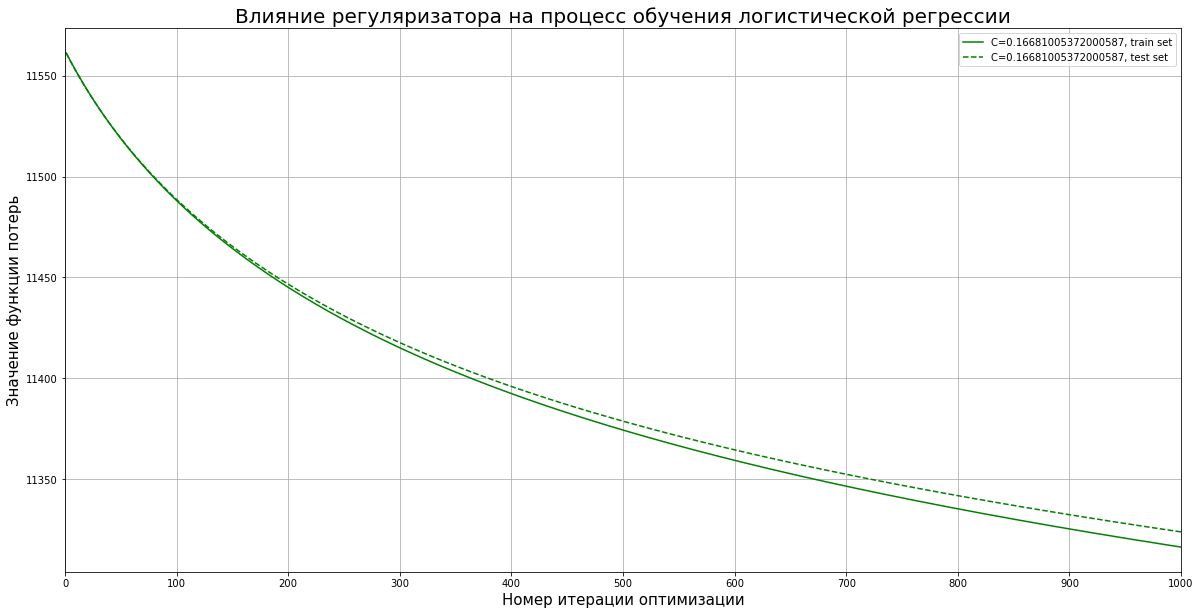

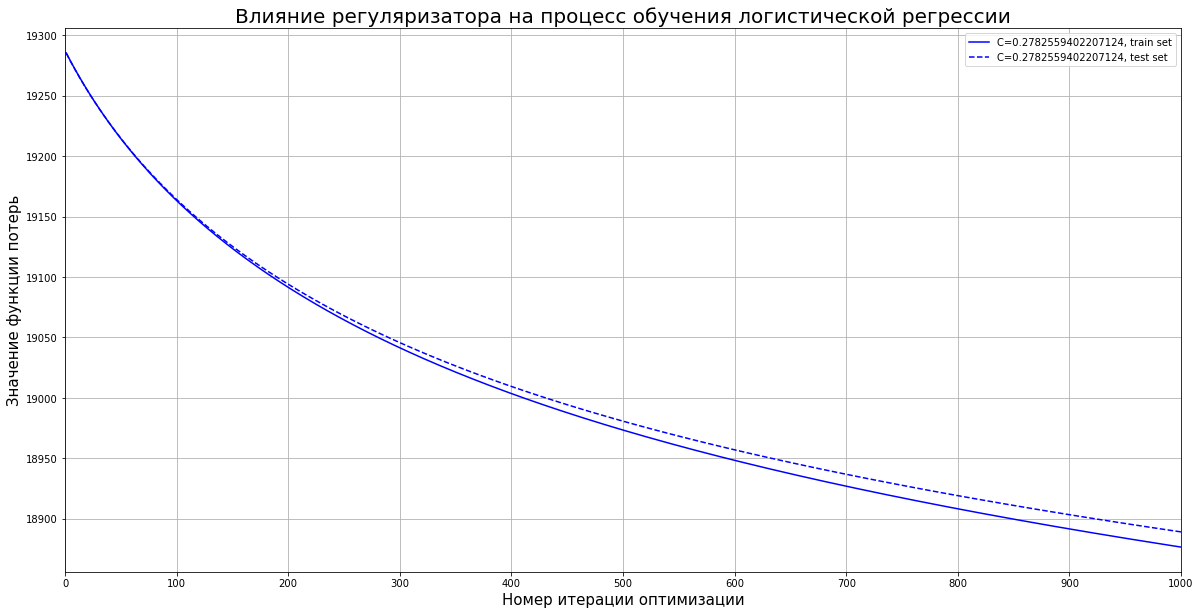

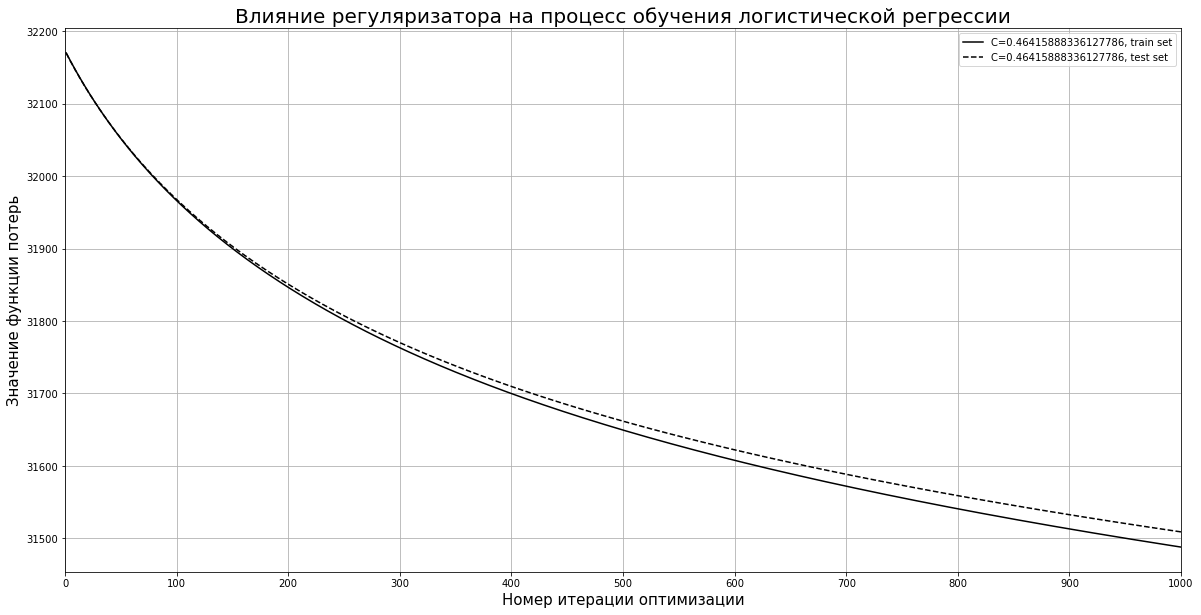

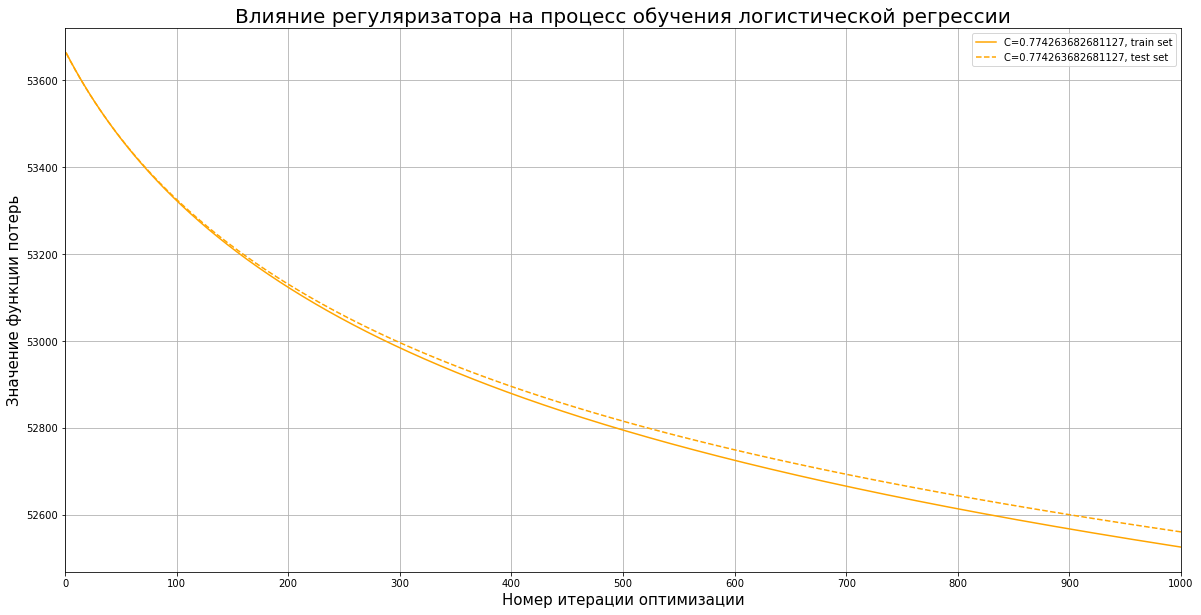

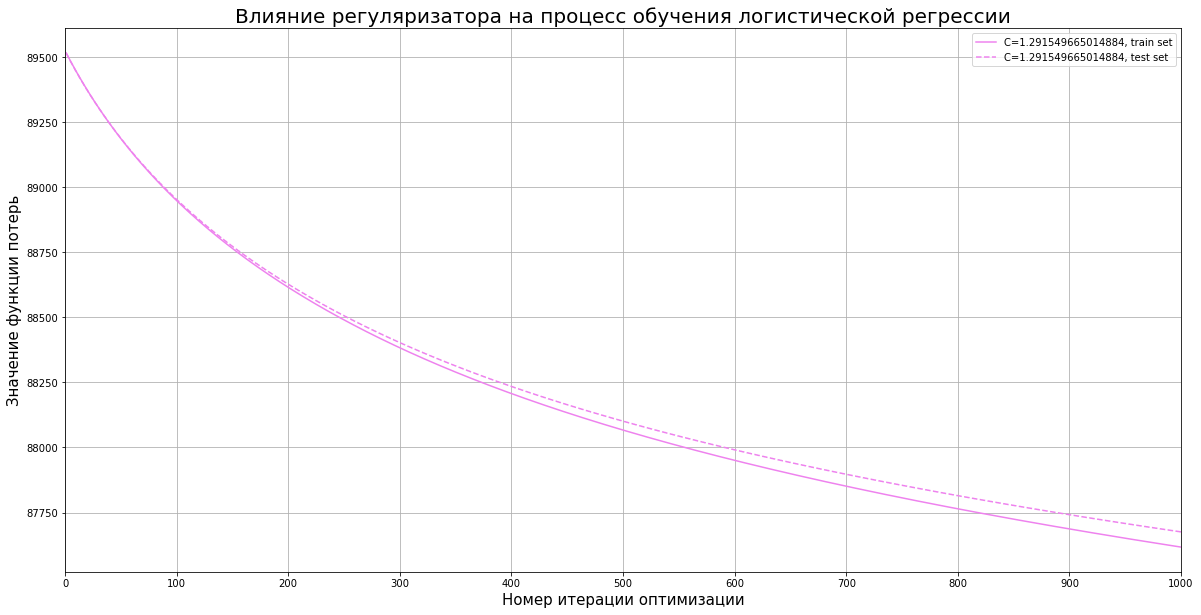

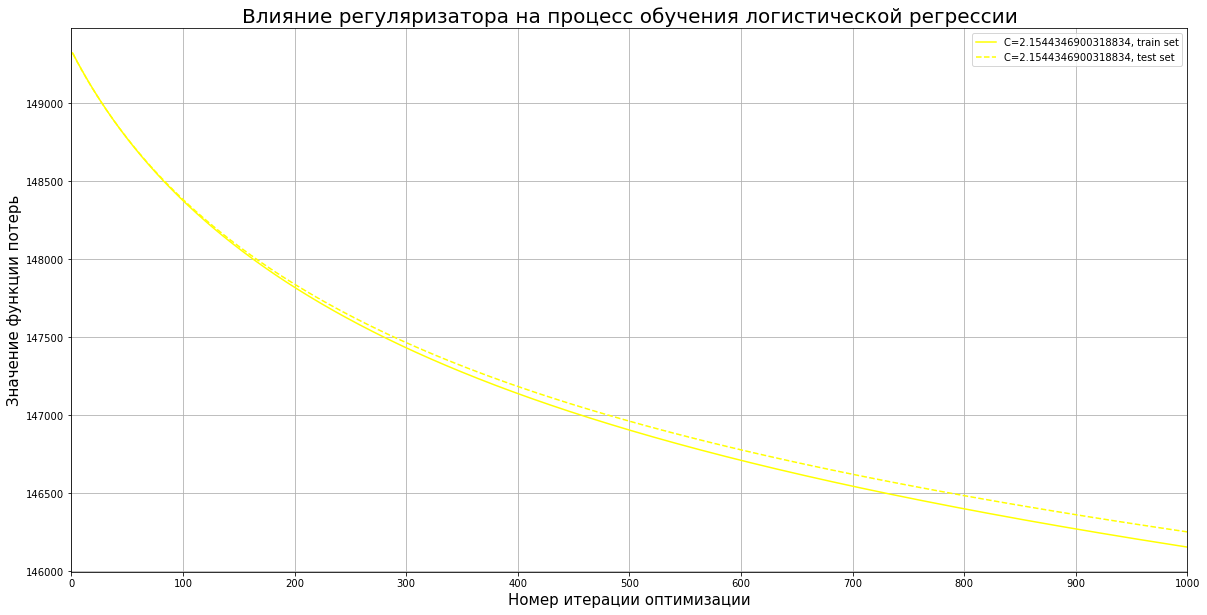

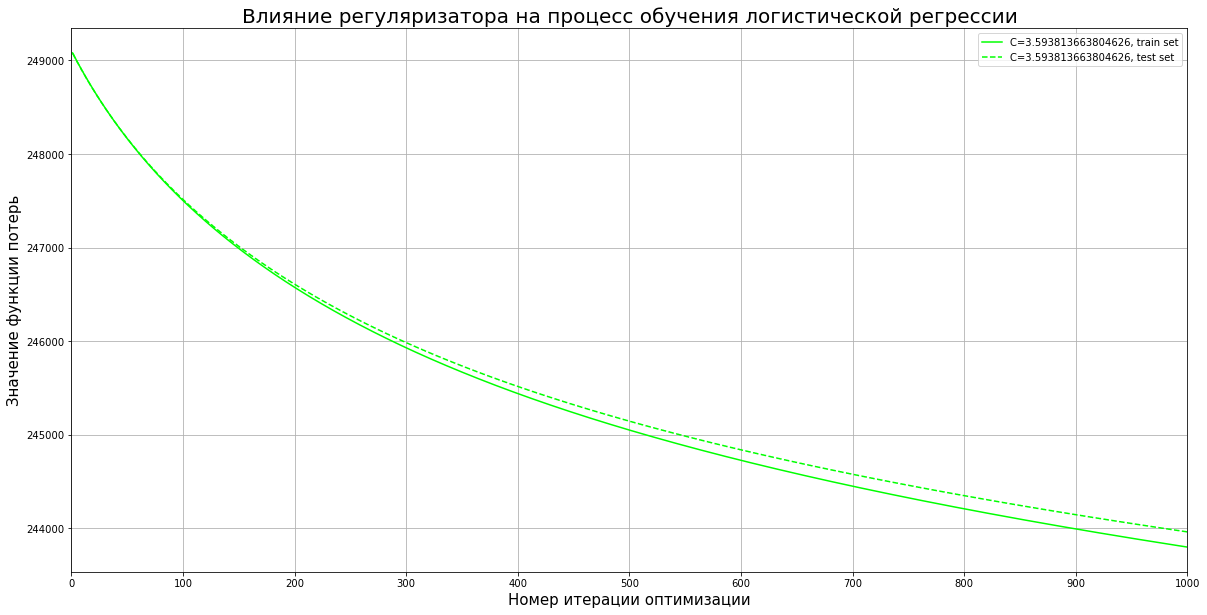

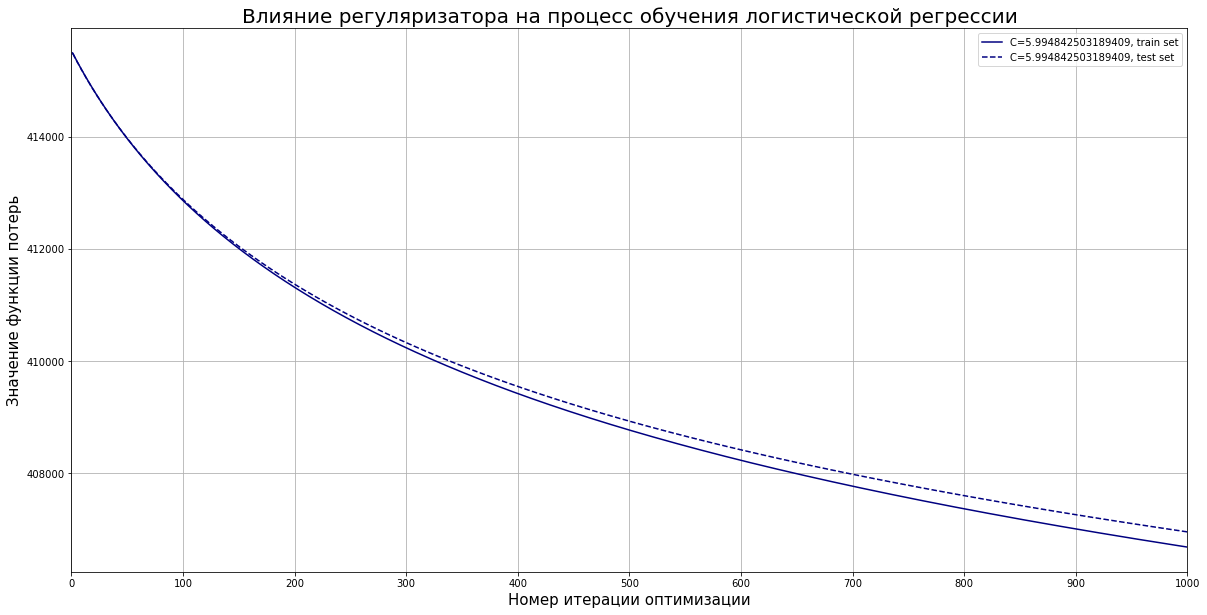

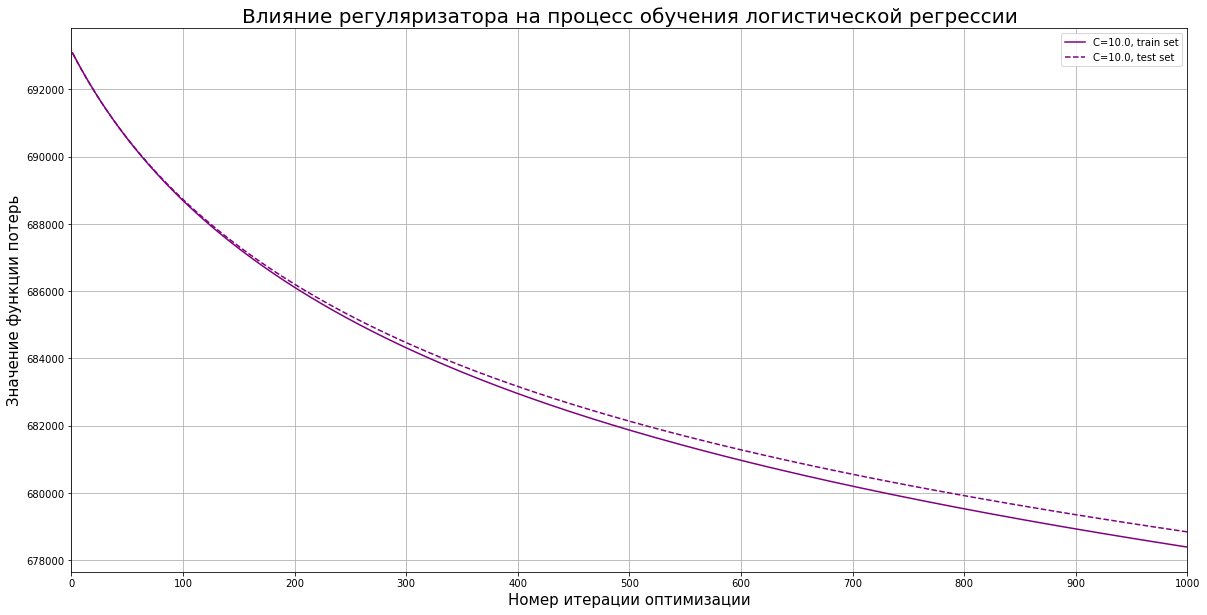

In [82]:
@ignore_warnings(category=ConvergenceWarning)
def plot_loss_func():
    reg_coefs = np.geomspace(0.1, 10.0, 10)
    colors = ['red', 'green', 'blue', 'black', 'orange', 'violet', 'yellow', 'lime', 'navy', 'purple']
    for reg_coef, color in zip(reg_coefs, colors):
        fig = plt.figure(figsize=(20, 10))
        plt.title('Влияние регуляризатора на процесс обучения логистической регрессии', fontsize=20)
        plt.xlabel('Номер итерации оптимизации', fontsize=15)
        plt.ylabel('Значение функции потерь', fontsize=15)
        plt.xlim([0, 1000])
        plt.xticks(np.arange(0, 1001, 100))
        plt.grid()
        log_reg = LogisticRegression(penalty='l2', C=reg_coef, solver='lbfgs', max_iter=1, warm_start=True, l1_ratio=None, tol=0.0001)
        loss_func_train = []
        loss_func_test = []
        for i in range(1000):
            log_reg.fit(X_train.to_numpy(), y_train)
            loss_func_train.append(0.5 * np.sum(log_reg.coef_.ravel() ** 2) + reg_coef * np.sum(np.log(np.exp(y_train_inverse * (np.matmul(X_train.to_numpy(), log_reg.coef_.ravel()) + log_reg.intercept_)) + 1)))
            loss_func_test.append(0.5 * np.sum(log_reg.coef_.ravel() ** 2) + reg_coef * np.sum(np.log(np.exp(y_test_inverse * (np.matmul(X_test.to_numpy(), log_reg.coef_.ravel()) + log_reg.intercept_)) + 1)))
        plt.plot(np.arange(1, 1001), loss_func_train, color=color, ls='-', label=f'С={reg_coef}, train set')
        plt.plot(np.arange(1, 1001), loss_func_test, color=color, ls='--', label=f'C={reg_coef}, test set')
        plt.legend()
        plt.show()
        
plot_loss_func()

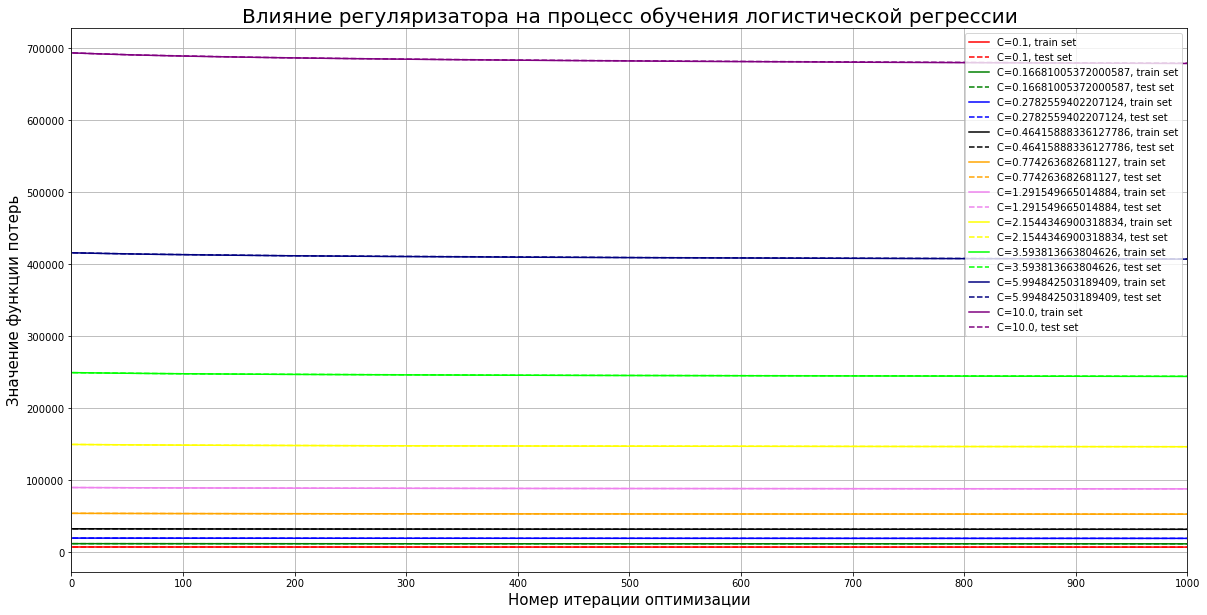

In [83]:
@ignore_warnings(category=ConvergenceWarning)
def plot_loss_func():
    reg_coefs = np.geomspace(0.1, 10.0, 10)
    colors = ['red', 'green', 'blue', 'black', 'orange', 'violet', 'yellow', 'lime', 'navy', 'purple']
    fig = plt.figure(figsize=(20, 10))
    plt.title('Влияние регуляризатора на процесс обучения логистической регрессии', fontsize=20)
    plt.xlabel('Номер итерации оптимизации', fontsize=15)
    plt.ylabel('Значение функции потерь', fontsize=15)
    plt.xlim([0, 1000])
    plt.xticks(np.arange(0, 1001, 100))
    plt.grid()
    for reg_coef, color in zip(reg_coefs, colors):
        log_reg = LogisticRegression(penalty='l2', C=reg_coef, solver='lbfgs', max_iter=1, warm_start=True, l1_ratio=None, tol=0.0001)
        loss_func_train = []
        loss_func_test = []
        for i in range(1000):
            log_reg.fit(X_train.to_numpy(), y_train)
            loss_func_train.append(0.5 * np.sum(log_reg.coef_.ravel() ** 2) + reg_coef * np.sum(np.log(np.exp(y_train_inverse * (np.matmul(X_train.to_numpy(), log_reg.coef_.ravel()) + log_reg.intercept_)) + 1)))
            loss_func_test.append(0.5 * np.sum(log_reg.coef_.ravel() ** 2) + reg_coef * np.sum(np.log(np.exp(y_test_inverse * (np.matmul(X_test.to_numpy(), log_reg.coef_.ravel()) + log_reg.intercept_)) + 1)))
        plt.plot(np.arange(1, 1001), loss_func_train, color=color, ls='-', label=f'С={reg_coef}, train set')
        plt.plot(np.arange(1, 1001), loss_func_test, color=color, ls='--', label=f'C={reg_coef}, test set')
    plt.legend()
    plt.show()
    
plot_loss_func()

Коэффициент регуляризации очень сильно влияет на значения функции потерь на обучающей и отложенной выборках, но сам вид функций почти одинаковый.

## Часть 4. Работа с категориальными переменными

### Задание 5. Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [63]:
log_reg = LogisticRegression(penalty='l2', C=0.7, solver='lbfgs', max_iter=10000, l1_ratio=None)
log_reg.fit(X_train.to_numpy(), y_train)
res = log_reg.predict_proba(X_test.to_numpy())
print(roc_auc_score(y_test, res[:, 1]))

0.6251333662019205


### Задание 6. Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [64]:
one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_one_hot = np.hstack((one_hot_enc.fit_transform(X_train[list(filter(lambda x: x.endswith('cat'), X_train.columns))].to_numpy()), X_train[list(filter(lambda x: not x.endswith('cat'), X_train.columns))].to_numpy()))
X_test_one_hot = np.hstack((one_hot_enc.transform(X_test[list(filter(lambda x: x.endswith('cat'), X_test.columns))].to_numpy()), X_test[list(filter(lambda x: not x.endswith('cat'), X_test.columns))].to_numpy()))

In [65]:
X_train_one_hot.shape

(100000, 226)

In [110]:
log_reg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [111]:
%%time

log_reg.fit(X_train_one_hot, y_train)

Wall time: 13.1 s


LogisticRegression(C=0.1, max_iter=10000)

In [112]:
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.6332478939187697


Качество модели улучшилось после one-hot кодирования. Модель обучалась на данных с закодированными категориальными признаками 13 секунд, а обучение до one-hot кодирования было быстрее 1 секунды.

### (Бонусная часть) Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы. Не забудьте замерить время.

In [6]:
X_train

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,1,5,0,0,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
106872,1,1,3,1,0,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
28943,6,2,7,1,0,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
851826,1,1,5,1,0,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
934813,0,1,1,0,4,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,1,5,0,0,0,1,0,0,0,...,9,1,0,5,1,1,1,0,1,0
697975,0,2,1,1,0,1,0,0,0,0,...,6,0,2,7,0,1,0,0,1,0
723907,5,1,3,1,0,0,1,0,0,0,...,6,2,1,7,0,0,0,1,0,0


In [25]:
def kfold(n, n_folds):
    if not isinstance(n, int) or not isinstance(n_folds, int) or n < 1 or n_folds < 2:
        raise AttributeError('Incorrect parameters')

    index_list = []
    d = n // n_folds
    for i in range(n_folds - 1):
        arr_val = np.arange(i * d, (i + 1) * d)
        arr_train = np.hstack((np.arange(0, i * d), np.arange((i + 1) * d, n)))
        index_list.append((arr_train, arr_val))
    index_list.append((np.arange((n_folds - 1) * d), np.arange((n_folds - 1) * d, n)))
    return index_list


def counters(x_train, y_train, x_test, cat_features, num_folds=None, timing=False):
    if timing:
        for feature in cat_features:
            x_train[feature], x_test[feature] = counters_maker_timing(x_train[feature].to_numpy().flatten(),
                                                                      x_test[feature].to_numpy().flatten(),
                                                                      y_train)
    else:
        if num_folds is None:
            for feature in cat_features:
                x_train[feature], x_test[feature] = counters_maker(x_train[feature].to_numpy().flatten(),
                                                                   x_test[feature].to_numpy().flatten(),
                                                                   y_train)
        else:
            for feature in cat_features:
                x_train[feature], x_test[feature] = counters_maker_folding(x_train[feature].to_numpy().flatten(),
                                                                           x_test[feature].to_numpy().flatten(),
                                                                           y_train, num_folds)


def counters_maker(x_train_feature, x_test_feature, target, a=0, b=0):
    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    x_train_res, x_test_res = np.empty(x_train_feature.shape[0], dtype=np.float64), \
                              np.full(x_test_feature.shape[0], -1, dtype=np.float64)

    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + a) / (counts[categories == cat][0] + b)
            x_train_res[x_train_feature == cat] = res
        else:
            res = a / (counts[categories == cat][0] + b)
            x_train_res[x_train_feature == cat] = res

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = 0.5
    return x_train_res, x_test_res


def counters_maker_folding(x_train_feature, x_test_feature, target, num_folds, c=10):
    index_list = kfold(x_train_feature.shape[0], num_folds)
    x_test_res = np.full(x_test_feature.shape[0], -1, dtype=np.float64)
    x_train_res = np.array([], dtype=np.float64)
    for index in index_list:
        categories, counts = np.unique(x_train_feature[index[0]], return_counts=True)
        categories_cond, counts_cond = np.unique(x_train_feature[index[0]][target[index[0]] == 1], return_counts=True)
        categories_fold = np.unique(x_train_feature[index[1]])
        x_fold_tmp = np.full(index[1].shape[0], -1, dtype=np.float64)
        global_mean = np.mean(target[index[0]])
        for cat in categories:
            if np.any(categories_cond == cat):
                res = (counts_cond[categories_cond == cat][0] + c * global_mean) / (counts[categories == cat][0] + c)
            else:
                res = c * global_mean / (counts[categories == cat][0] + c)

            if np.any(categories_fold == cat):
                x_fold_tmp[x_train_feature[index[1]] == cat] = res

        x_fold_tmp[x_fold_tmp == -1.0] = global_mean
        x_train_res = np.append(x_train_res, x_fold_tmp)

    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    global_mean = np.mean(target)
    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + c * global_mean) / (counts[categories == cat][0] + c)
        else:
            res = c * global_mean / (counts[categories == cat][0] + c)

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = global_mean
    return x_train_res, x_test_res


def counters_maker_timing(x_train_feature, x_test_feature, target):
    cat_train = np.unique(x_train_feature)
    x_train_res = np.empty(x_train_feature.shape[0], dtype=np.float64)
    x_train_res[0] = 0.5
    for cat in np.unique(x_test_feature):
        if np.any(cat_train == cat):
            x_test_feature[x_test_feature == cat] = np.sum(target[x_train_feature == cat]) / np.sum(x_train_feature == cat)
        else:
            x_test_feature[x_test_feature == cat] = 0.5
    for i in range(1, x_train_res.shape[0]):
        if np.any(x_train_feature[i] == x_train_feature[0:i]):
            x_train_res[i] = np.sum(target[0:i][x_train_feature[0:i] == x_train_feature[i]]) / np.sum(x_train_feature[0:i] == x_train_feature[i])
        else:
            x_train_res[i] = 0.5
    return x_train_res, x_test_feature

In [8]:
list(filter(lambda x: x.endswith('cat'), X_train.columns))

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [46]:
X_train_counter1 = X_train.copy()
X_test_counter1 = X_test.copy()
counters(X_train_counter1, y_train, X_test_counter1, filter(lambda x: x.endswith('cat'), X_train.columns))

In [47]:
X_train_counter1

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,0.495424,5,0.486512,0.479374,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
106872,1,0.495424,3,0.516808,0.479374,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
28943,6,0.508632,7,0.516808,0.479374,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
851826,1,0.495424,5,0.516808,0.479374,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
934813,0,0.495424,1,0.486512,0.611746,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,0.495424,5,0.486512,0.479374,0,1,0,0,0,...,9,1,0,5,1,1,1,0,1,0
697975,0,0.508632,1,0.516808,0.479374,1,0,0,0,0,...,6,0,2,7,0,1,0,0,1,0
723907,5,0.495424,3,0.516808,0.479374,0,1,0,0,0,...,6,2,1,7,0,0,0,1,0,0


In [48]:
for cat_feature in filter(lambda x: x.endswith('cat'), X_train.columns):
    X_train_counter1[cat_feature] = X_train_counter1[cat_feature] + 0.001 * np.random.randn(X_train_counter1.shape[0])

In [49]:
X_train_counter1

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,0.495858,5,0.487742,0.481227,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
106872,1,0.496550,3,0.516931,0.479698,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
28943,6,0.509085,7,0.516953,0.478457,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
851826,1,0.496100,5,0.517425,0.478946,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
934813,0,0.493370,1,0.485235,0.611747,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,0.496363,5,0.488366,0.481081,0,1,0,0,0,...,9,1,0,5,1,1,1,0,1,0
697975,0,0.508506,1,0.516222,0.480169,1,0,0,0,0,...,6,0,2,7,0,1,0,0,1,0
723907,5,0.495116,3,0.516626,0.479754,0,1,0,0,0,...,6,2,1,7,0,0,0,1,0,0


In [50]:
log_reg = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [51]:
%%time

log_reg.fit(X_train_counter1, y_train)

Wall time: 8.17 s


LogisticRegression(C=0.4, max_iter=10000)

In [52]:
res = log_reg.predict_proba(X_test_counter1)
print(roc_auc_score(y_test, res[:, 1]))

0.6287578734541133


Качество модели на метрике ROC-AUC увеличилось по сравнению с моделью без какого-либо кодирования категориальных признаков, но качество с one-hot кодированием выше, чем с таким видом счетчиков. Скорее всего нужны счетчики со сглаживанием для более высокого качества.

### (Бонусная часть) Посчитайте корректные счётчики, основываясь на объектах расположеных выше в датасете (не забудьте добавить и шум).

In [53]:
X_train_counter2 = X_train.copy()
X_test_counter2 = X_test.copy()
counters(X_train_counter2, y_train, X_test_counter2, filter(lambda x: x.endswith('cat'), X_train.columns), timing=True)

In [54]:
X_train_counter2

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,0.500000,5,0.500000,0.500000,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
106872,1,0.000000,3,0.500000,0.000000,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
28943,6,0.500000,7,1.000000,0.500000,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
851826,1,0.500000,5,0.500000,0.333333,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
934813,0,0.666667,1,0.000000,0.500000,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,0.495438,5,0.486512,0.479378,0,1,0,0,0,...,9,1,0,5,1,1,1,0,1,0
697975,0,0.508609,1,0.516820,0.479384,1,0,0,0,0,...,6,0,2,7,0,1,0,0,1,0
723907,5,0.495445,3,0.516832,0.479390,0,1,0,0,0,...,6,2,1,7,0,0,0,1,0,0


In [55]:
for cat_feature in filter(lambda x: x.endswith('cat'), X_train.columns):
    X_train_counter2[cat_feature] = X_train_counter2[cat_feature] + 0.001 * np.random.randn(X_train_counter2.shape[0])

In [56]:
X_train_counter2

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,0.501770,5,0.499601,0.499005,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
106872,1,0.000415,3,0.499762,0.000435,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
28943,6,0.500825,7,1.000298,0.498185,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
851826,1,0.499483,5,0.499881,0.333041,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
934813,0,0.666342,1,-0.000483,0.499901,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,0.496595,5,0.484299,0.478718,0,1,0,0,0,...,9,1,0,5,1,1,1,0,1,0
697975,0,0.507437,1,0.516697,0.480011,1,0,0,0,0,...,6,0,2,7,0,1,0,0,1,0
723907,5,0.496275,3,0.516184,0.479544,0,1,0,0,0,...,6,2,1,7,0,0,0,1,0,0


In [57]:
log_reg = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [58]:
%%time

log_reg.fit(X_train_counter2, y_train)

Wall time: 6.49 s


LogisticRegression(C=0.4, max_iter=10000)

In [59]:
res = log_reg.predict_proba(X_test_counter2)
print(roc_auc_score(y_test, res[:, 1]))

0.6089522471689124


С этим типом счетчиков качество ухудшилось даже по сравнению с моделью без кодирования категориальных признаков.

### Задание 7. Реализуйте счетчики со сглаживанием, как описано выше. Обучите логистическую регрессию, оцените качество.

Если некоторая категория встречается в выборке всего несколько раз, то счетчик по этой категории будет нести неточное значение о целевой переменной. Поэтому делают сглаживание.

In [26]:
X_train_counter_smooth = X_train.copy()
X_test_counter_smooth = X_test.copy()
counters(X_train_counter_smooth, y_train, X_test_counter_smooth, filter(lambda x: x.endswith('cat'), X_train.columns), num_folds=3)

In [27]:
X_train_counter_smooth

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1049183,0,0.494198,5,0.486788,0.478602,1,0,0,0,0,...,4,3,4,6,0,0,0,0,0,0
106872,1,0.494198,3,0.514154,0.478602,0,1,0,0,0,...,9,0,4,12,0,1,1,0,0,0
28943,6,0.506797,7,0.514154,0.478602,0,0,1,0,0,...,4,1,2,7,0,1,1,0,1,0
851826,1,0.494198,5,0.514154,0.478602,0,0,1,0,0,...,6,2,2,10,0,0,1,0,0,0
934813,0,0.494198,1,0.486788,0.604515,1,0,0,0,0,...,9,1,2,14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624097,3,0.496434,5,0.485635,0.479128,0,1,0,0,0,...,9,1,0,5,1,1,1,0,1,0
697975,0,0.507858,1,0.518805,0.479128,1,0,0,0,0,...,6,0,2,7,0,1,0,0,1,0
723907,5,0.496434,3,0.518805,0.479128,0,1,0,0,0,...,6,2,1,7,0,0,0,1,0,0


In [43]:
log_reg = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [44]:
%%time

log_reg.fit(X_train_counter_smooth, y_train)

Wall time: 10.3 s


LogisticRegression(C=0.4, max_iter=10000)

In [45]:
res = log_reg.predict_proba(X_test_counter_smooth)
print(roc_auc_score(y_test, res[:, 1]))

0.6288938062560709


Счетчики со сглаживанием и фолдингом дали самый лучший результат среди рассмотренных типов счетчиков. Но на этих данных one-hot кодирование все равно показывает лучшее качество.

Плюсы счетчиков перед one-hot кодированием:
* не увеличивают признаковое пространство
* несут много информации о целевой переменной

Минусы счетчиков перед one-hot кодированием:
* сложнее в реализации
* не всегда дают лучшее качество модели

## Отбор признаков

In [66]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [90]:
one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_one_hot = np.hstack((one_hot_enc.fit_transform(X_train[list(filter(lambda x: x.endswith('cat'), X_train.columns))].to_numpy()), X_train[list(filter(lambda x: not x.endswith('cat'), X_train.columns))].to_numpy()))
X_test_one_hot = np.hstack((one_hot_enc.transform(X_test[list(filter(lambda x: x.endswith('cat'), X_test.columns))].to_numpy()), X_test[list(filter(lambda x: not x.endswith('cat'), X_test.columns))].to_numpy()))

In [91]:
X_train_one_hot.shape

(476169, 227)

Получилось 227 признаков.

In [69]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.6385026688042603


### Встроенные методы

### Задание 8. Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков (время обучения нашего метода отбора).

In [70]:
%%time

log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
coef_abs = np.abs(log_reg.coef_.ravel())
min_index = []
max_coef = np.max(coef_abs) + 1
for i in range(27):
    min_index.append(np.argmin(coef_abs))
    coef_abs[min_index[-1]] = max_coef
true_index = np.ones(227)
true_index[min_index] = 0
X_train_one_hot = X_train_one_hot[:, true_index.astype(bool)]
X_test_one_hot = X_test_one_hot[:, true_index.astype(bool)]

Wall time: 1min 37s


In [71]:
X_train_one_hot.shape

(476169, 200)

In [72]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.6385991236612067


Встроенный метод отбора признаков работал 1 минуту 37 секунд. 

Качество немного увеличилось по сравнению с моделью без отбора признаков.

In [75]:
for i in range(227):
    train_mean = np.mean(X_train_one_hot[:, i])
    train_std = np.std(X_train_one_hot[:, i])
    X_train_one_hot[:, i] = (X_train_one_hot[:, i] - train_mean) / train_std
    X_test_one_hot[:, i] = (X_test_one_hot[:, i] - train_mean) / train_std

In [81]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.6380807781568106


In [82]:
%%time

log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
coef_abs = np.abs(log_reg.coef_.ravel())
min_index = []
max_coef = np.max(coef_abs) + 1
for i in range(27):
    min_index.append(np.argmin(coef_abs))
    coef_abs[min_index[-1]] = max_coef
true_index = np.ones(227)
true_index[min_index] = 0
X_train_one_hot = X_train_one_hot[:, true_index.astype(bool)]
X_test_one_hot = X_test_one_hot[:, true_index.astype(bool)]

Wall time: 5.86 s


In [83]:
X_train_one_hot.shape

(476169, 200)

In [84]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.6380246530254693


Получилось, что качество только ухудшилось.

Встроенный метод отбора признаков в таком случае работал намного быстрее: примерно 6 секунд.

### Методы фильтрации

### Задание 9. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков (время обучения нашего метода отбора) в этом случае.

In [87]:
%%time

filter_fun = []
max_index = []
for i in range(227):
    fea = X_train_one_hot[:, i]
    filter_fun.append(math.fabs(np.mean(fea[y_train == 1]) - np.mean(fea[y_train == 0])) / math.sqrt((np.sum(y_train == 1) * np.var(fea[y_train == 1]) + np.sum(y_train == 0) * np.var(fea[y_train == 0])) / y_train.shape[0]))
filter_fun = np.array(filter_fun)
for i in range(200):
    max_index.append(np.argmax(filter_fun))
    filter_fun[max_index[-1]] = -1
X_train_one_hot = X_train_one_hot[:, max_index]
X_test_one_hot = X_test_one_hot[:, max_index]

Wall time: 3.87 s


In [88]:
X_train_one_hot.shape

(476169, 200)

In [89]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.638935545630464


Качество с таким методом отбора признаков получилось самым высоким на данный момент. При этом сам метод фильтрации признаков работал быстро: почти 4 секунды.

### Методы-обёртки

### Задание 10.

In [92]:
X_train_fit, X_train_val, y_train_fit, y_train_val = train_test_split(X_train_one_hot, y_train, test_size=0.5, random_state=777)

In [93]:
%%time

log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_fit[:, 1:], y_train_fit)
res = log_reg.predict_proba(X_train_val[:, 1:])
roc_auc_score(y_train_val, res[:, 1])

Wall time: 36 s


0.6266617843517561

Такой отбор признаков займет слишком много времени: 36 * 5778 сек, а это почти 2.5 суток.

In [97]:
X_train_fit, X_train_val, y_train_fit, y_train_val = train_test_split(X_train_one_hot, y_train, train_size=20000, random_state=777)
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
indexes = np.arange(227)

In [98]:
%%time

for i in range(27):
    max_score = -1
    for j in range(227 - i):
        mask = np.ones(227 - i)
        mask[j] = 0
        log_reg.fit(X_train_fit[:, mask.astype(bool)], y_train_fit)
        res = log_reg.predict_proba(X_train_val[:, mask.astype(bool)])
        score = roc_auc_score(y_train_val, res[:, 1])
        if score > max_score:
            max_score = score
            index = j
    indexes = np.delete(indexes, index)
    mask = np.ones(227 - i)
    mask[index] = 0
    X_train_fit = X_train_fit[:, mask.astype(bool)]
    X_train_val = X_train_val[:, mask.astype(bool)]
    
X_train_one_hot = X_train_one_hot[:, indexes]
X_test_one_hot = X_test_one_hot[:, indexes]

Wall time: 1h 54min 28s


In [99]:
X_train_one_hot.shape

(476169, 200)

In [100]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.6387403967211223


Качество на тестовой выборке по метрике ROC-AUC с таким способом отбора признаков составило примерно 0.6387. 

Такой алгоритм отбора признаков работал почти 2 часа.

Итоги по отбору признаков:
* Встроенные методы
    * Приемущества: простота реализации
    * Недостатки: может долго обучаться, дает не очень хорошее качество, зависит от масштаба признаков
* Методы фильтрации
    * Приемущества: дают отличный результат, быстро обучаются, интуитивно понятные, простые в реализации
* Методы обертки
    * Приемущества: дают хороший результат
    * Недостатки: очень долго обучаются, сложнее остальных методов в реализации

Метод фильтрации признаков привел к наилучшему качеству, при этом он работал намного быстрее всех остальных методов отбора признаков.

## Настройка порога для бинаризации вероятностей

In [101]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [102]:
print(np.sum(target) / target.shape[0])

0.036447517859182946


В выборке такая маленькая доля положительных объектов, потому что страховые случаи происходят редко.

In [103]:
one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_one_hot = np.hstack((one_hot_enc.fit_transform(X_train[list(filter(lambda x: x.endswith('cat'), X_train.columns))].to_numpy()), X_train[list(filter(lambda x: not x.endswith('cat'), X_train.columns))].to_numpy()))
X_test_one_hot = np.hstack((one_hot_enc.transform(X_test[list(filter(lambda x: x.endswith('cat'), X_test.columns))].to_numpy()), X_test[list(filter(lambda x: not x.endswith('cat'), X_test.columns))].to_numpy()))

In [104]:
filter_fun = []
max_index = []
for i in range(227):
    fea = X_train_one_hot[:, i]
    filter_fun.append(math.fabs(np.mean(fea[y_train == 1]) - np.mean(fea[y_train == 0])) / math.sqrt((np.sum(y_train == 1) * np.var(fea[y_train == 1]) + np.sum(y_train == 0) * np.var(fea[y_train == 0])) / y_train.shape[0]))
filter_fun = np.array(filter_fun)
for i in range(200):
    max_index.append(np.argmax(filter_fun))
    filter_fun[max_index[-1]] = -1
X_train_one_hot = X_train_one_hot[:, max_index]
X_test_one_hot = X_test_one_hot[:, max_index]

In [105]:
log_reg = LogisticRegression(penalty='l2', C=0.05, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)
log_reg.fit(X_train_one_hot, y_train)
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.638935545630464


Качество по метрике ROC-AUC получилось небольшим, потому что классы очень сильно несбалансированны: объектов положительного класса сильно меньше, чем объектов отрицательного класса.

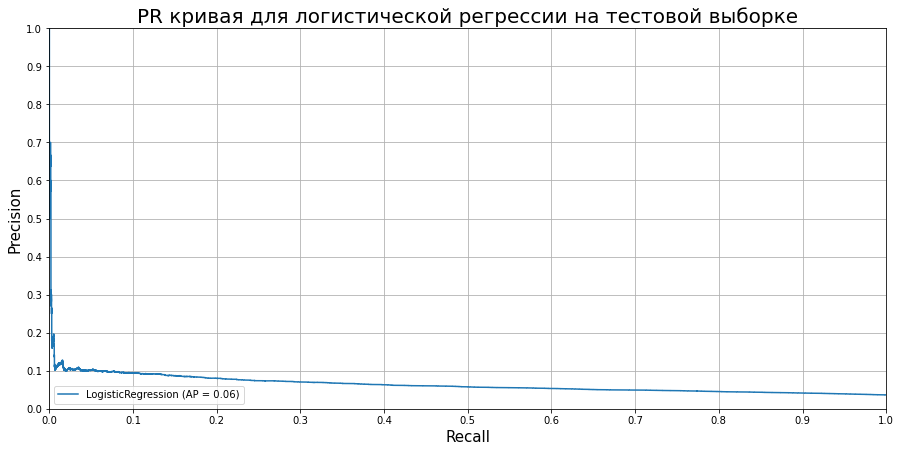

In [106]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.set_title('PR кривая для логистической регрессии на тестовой выборке', fontsize=20)
ax.set_xlabel('Recall', fontsize=15)
ax.set_ylabel('Precision', fontsize=15)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()
plot_precision_recall_curve(log_reg, X_test_one_hot, y_test, ax=ax)
plt.show()

По PR кривой видно, что даже среди объектов, которым модель предсказала самые высокие вероятности принадлежности к положительному классу, очень много объектов отрицательного класса. Поэтому PR кривая так резко падает в самом начале. Это обусловленно тем, что классы очень сильно несбалансированны.

### Задание 11.

In [113]:
pos_prob = res[:, 1]
y_test_sorted = y_test[np.argsort(pos_prob)]
pos_prob_sorted = np.sort(pos_prob)
threshold = -1
for i in range(pos_prob_sorted.shape[0]):
    if np.sum(y_test_sorted[i:]) / (y_test_sorted.shape[0] - i) >= 0.95:
        threshold = pos_prob_sorted[i]
        break
        
print(threshold)
# >= threshold => positive

0.38801427153747986


In [114]:
print(precision_score(y_test, (pos_prob >= threshold).astype(int)))

1.0


In [115]:
print(recall_score(y_test, (pos_prob >= threshold).astype(int)))

0.00023142791020597085


Соответствующий порог равен 0.38801427153747986. Precision и recall на таком пороге будут соответсвенно равны 1.0 и 0.00023142791020597085.

Мы откажем только одному клиенту, то есть примерно 0.0000084 части потенциальных клиентов. При этом мы одобрим страхование очень многим людям, у которых страховой случай на самом деле произойдет, поэтому такой низкий recall.

### Задание 12. Найдите такой порог, при котором наш баланс (разница между доходами и расходами на группе клиентов, которым мы отказали) неотрицательный.

In [118]:
np.sum(y_test == 1) * 100000 - np.sum(y_test == 0) * 5000

-141510000

In [119]:
pos_prob = res[:, 1]
y_test_sorted = y_test[np.argsort(pos_prob)]
pos_prob_sorted = np.sort(pos_prob)
for i in range(pos_prob_sorted.shape[0]):
    if np.sum(y_test_sorted[i:]) * 100000 - np.sum(y_test_sorted[i:] == 0) * 5000 >= 0:
        threshold = pos_prob_sorted[i]
        break
        
print(threshold)
# >= threshold => positive

0.029337137648917034


In [122]:
np.sum(pos_prob >= threshold)

68418

In [124]:
pos_prob.shape

(119043,)

Порог, при котором наш баланс неотрицательный, равен 0.029337137648917034.
С таким порогом мы откажем 68418 клиентам из 119043 потенциальных клиентов.

In [125]:
pos_prob = res[:, 1]
y_test_sorted = y_test[np.argsort(pos_prob)]
pos_prob_sorted = np.sort(pos_prob)
max_balance = -1
for i in range(pos_prob_sorted.shape[0]):
    if np.sum(y_test_sorted[i:]) * 100000 - np.sum(y_test_sorted[i:] == 0) * 5000 > max_balance:
        max_balance = np.sum(y_test_sorted[i:]) * 100000 - np.sum(y_test_sorted[i:] == 0) * 5000
        threshold = pos_prob_sorted[i]
        
print(threshold)
# >= threshold => positive

0.04694308749924309


In [126]:
np.sum(pos_prob >= threshold)

23808

Баланс максимален при пороге 0.04694308749924309. С таким порогом мы откажем 23808 клиентам из 119043 потенциальных клиентов.